## Figure notebook for annotating single-nuclei RNA-seq datasets (from neurips 2021, S1D1 multiome)

Last updated: 1/2/2022
Author: Yang-Joon Kim

Notse: 
- We will use the neurips 2021, s1d1 (RNA+ATAC) objects, only for the RNA part.
- We will use a subset of cell-types for UMAP visualizations for simplicity



In [5]:
import os
import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from skimage.measure import block_reduce
import tifffile
import string
from sklearn.metrics import confusion_matrix

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
def set_plotting_style_huge():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=24)
    plt.rc('axes', titlesize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=20)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=4)
    plt.rc('ytick.major', pad=4)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
        
    
# Function to preprocess raw AnnData object

def preprocess_ad(ad, min_counts):
    ad.layers['counts'] = ad.X.copy()
    sc.pp.filter_cells(ad, min_counts=min_counts)
    sc.pp.normalize_total(ad, target_sum=1e4) # Normalize data
    sc.pp.log1p(ad) # Logarithmize the data
    sc.pp.scale(ad) # Scale each gene to unit variance

In [6]:
# load utilities module
sys.path.append("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/excellxgene_tutorials/utilities/")
import color_schema

In [7]:
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [8]:
# define the figure path
figpath = "/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/excellxgene_tutorials/figures/Figure_RNA_knownCelltype_markers/"
sc.settings.figdir = figpath
set_plotting_style()

## Figure scheme

- (A): UMAP embedding - no color
- (B): schematics showing the dictionary of cell-types: marker genes
- (C): UMAP with marker genes for T cell subtypes (CD3E, etc.)
- (D): subclustered UMAP 
- (E): sub-clustering for making a child UMAP


**Which annotation to be used per celltype**

(Plotting specific marker genes for clarification below)

From RNA:
- CD14+ Mono
- ID2-hi myeloid prog
- CD16+ Mono
- NK
- ILC
- cDC2
- Reticulocyte
- Erythroblast
- Proerythroblast
- HSC

From ATAC:
- CD4+ T activated
- CD4+ T naive
- CD8+ T
- Lymph prog
- naive CD20+ B
- B1 B
- Transitional B
- pDCs
- G/M prog: ('HSPC' in ATAC)
- MK/E prog
- Plasma cells


Notes:


In [10]:
# import the dataset
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_processed_annotated_forViz.h5ad")
adata

AnnData object with n_obs × n_vars = 6224 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'annotation_for_visualization'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    obsm: 'X_latent_pca', 'X_pca', 'X_umap'
    layers: 'X', 'counts'
    obsp: 'N_pca', 'N_umap'

In [12]:
adata.obs["annotation_for_visualization"].unique()

['unassigned', 'T_cells']
Categories (2, object): ['T_cells', 'unassigned']

In [ ]:
adata.obs["annotation_for_visualization"].unique()

In [6]:
# edit the gene names as we've added "-RNA" or "-ATAC" to merge the two modalities
#RNA
marker_genes_rna = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers
    'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'],
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],
    'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
    'B1 B': ['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'], # Note IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'RF4', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDCs': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'],
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'],
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'RYR3', 'PLCB1'] # Note PLCB1 is a negative marker
}

for cell_type in marker_genes_rna:
    genes = marker_genes_rna[cell_type]
    new_genes = [gene + "-RNA" for gene in genes]
    marker_genes_rna[cell_type] = new_genes
    
marker_genes_rna

#ATAC
marker_genes_atac = {
    'CD14+ Mono': ['TREM1', 'FPR1'],
    'CD16+ Mono': ['LYN', 'TCF7L2'],
    'ID2-hi myeloid prog': ['KLF4'],
    'cDC2': ['TREM1', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['GATA1', 'HBA1', 'SLC4A1', 'SLC25A37', 'KLF1'],
    'Erythroblast': ['GATA1', 'MKI67'],
    'Proerythroblast': ['GATA2', 'CRACD', 'SYNGR1'],
    'NK': ['CD160', 'GNLY', 'GRIK4', 'CD247'],
    'ILC': ['SPON2', 'GZMB', 'PRF1', 'C69'], # Note CD69 should be negative
    'Lymph prog': ['MME', 'IGLL1', 'VPREB1', 'CD79B'],
    'Naive CD20+ B': ['MS4A1', 'LYN', 'CD74', 'BLK'],
    'B1 B': ['ITGB1', 'MS4A1', 'DUSP22', 'EPHA4'],
    'Transitional B': ['MME', 'CD38', 'CD24'],
    'Plasma cells': ['DUSP22', 'FNDC3B'],
    'CD4+ T activated': ['JAKMIP1', 'C4orf50'],
    'CD4+ T naive': [ 'BCL11B', 'BACH2', 'JAKMIP1', 'C4orf50'], # Note JAKMIP1 and C4orf50 are negative markers
    'CD8+ T': ['CD8A', 'CD8B'],
    'pDCs': ['PTPRS', 'TCF4', 'KCNN3', 'DUSP22'],
    'G/M prog': ['MPO','NT5DC3'],
    'HSC': ['PRDM16','TAMALIN','MTRNR2L1'],
    'MK/E prog': ['DNAJC6']
}

for cell_type in marker_genes_atac:
    genes = marker_genes_atac[cell_type]
    new_genes = [gene + "-ATAC" for gene in genes]
    marker_genes_atac[cell_type] = new_genes
    
marker_genes_atac

{'CD14+ Mono': ['TREM1-ATAC', 'FPR1-ATAC'],
 'CD16+ Mono': ['LYN-ATAC', 'TCF7L2-ATAC'],
 'ID2-hi myeloid prog': ['KLF4-ATAC'],
 'cDC2': ['TREM1-ATAC', 'DMXL2-ATAC'],
 'Reticulocyte': ['GATA1-ATAC',
  'HBA1-ATAC',
  'SLC4A1-ATAC',
  'SLC25A37-ATAC',
  'KLF1-ATAC'],
 'Erythroblast': ['GATA1-ATAC', 'MKI67-ATAC'],
 'Proerythroblast': ['GATA2-ATAC', 'CRACD-ATAC', 'SYNGR1-ATAC'],
 'NK': ['CD160-ATAC', 'GNLY-ATAC', 'GRIK4-ATAC', 'CD247-ATAC'],
 'ILC': ['SPON2-ATAC', 'GZMB-ATAC', 'PRF1-ATAC', 'C69-ATAC'],
 'Lymph prog': ['MME-ATAC', 'IGLL1-ATAC', 'VPREB1-ATAC', 'CD79B-ATAC'],
 'Naive CD20+ B': ['MS4A1-ATAC', 'LYN-ATAC', 'CD74-ATAC', 'BLK-ATAC'],
 'B1 B': ['ITGB1-ATAC', 'MS4A1-ATAC', 'DUSP22-ATAC', 'EPHA4-ATAC'],
 'Transitional B': ['MME-ATAC', 'CD38-ATAC', 'CD24-ATAC'],
 'Plasma cells': ['DUSP22-ATAC', 'FNDC3B-ATAC'],
 'CD4+ T activated': ['JAKMIP1-ATAC', 'C4orf50-ATAC'],
 'CD4+ T naive': ['BCL11B-ATAC', 'BACH2-ATAC', 'JAKMIP1-ATAC', 'C4orf50-ATAC'],
 'CD8+ T': ['CD8A-ATAC', 'CD8B-ATAC'],
 'pD

In [7]:
marker_genes_rna["CD4+ T activated"]
marker_genes_rna["CD4+ T naive"]

['CD4-RNA', 'IL7R-RNA', 'TRBC2-RNA', 'CCR7-RNA']

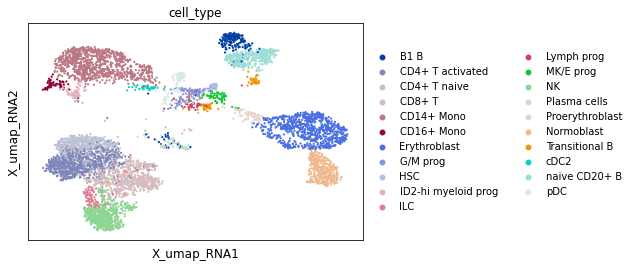

In [8]:
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["cell_type"])

In [ ]:
# Check the coarse cell-types using some pan-marker genes
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["CD3E-RNA","CD79B-RNA","KRT8-RNA",""],
                ncols=2)

### marker genes for T-cell subtypes

- 'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1']
- 'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7']
- 'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA']
- 'T activation': ['CD69', 'CD38'] # CD69 much better marker!
- 'T naive': ['LEF1', 'CCR7', 'TCF7']
- 'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1']
- 'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A']

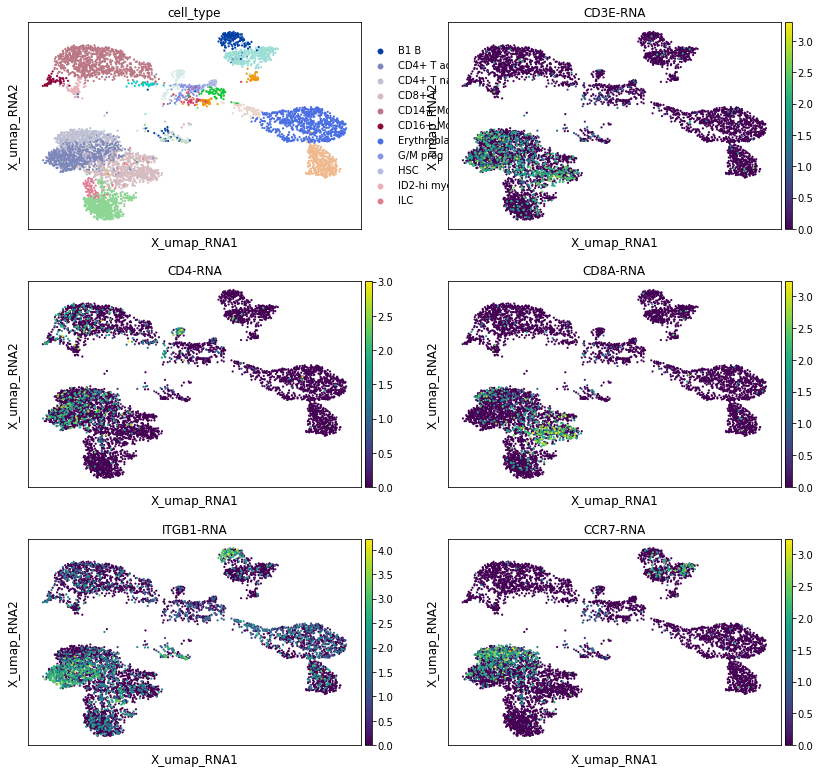

In [9]:
# dissection for the T-cell subtypes
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["cell_type","CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                ncols=2)

In [ ]:
sc.pl.embedding(adata[adata.obs["cell_type"].isin([""])], basis="X_umap_RNA", 
                color=["cell_type","CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                ncols=2)

## Histogram for marker genes
(for selection of cells based on expression levels)


In [16]:
adata.obs["cell_type"].unique().to_list()

['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Erythroblast',
 'CD8+ T',
 'naive CD20+ B',
 'CD14+ Mono',
 'HSC',
 'NK',
 'pDC',
 'B1 B',
 'G/M prog',
 'Normoblast',
 'CD16+ Mono',
 'MK/E prog',
 'ILC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'cDC2',
 'Transitional B',
 'Plasma cells']

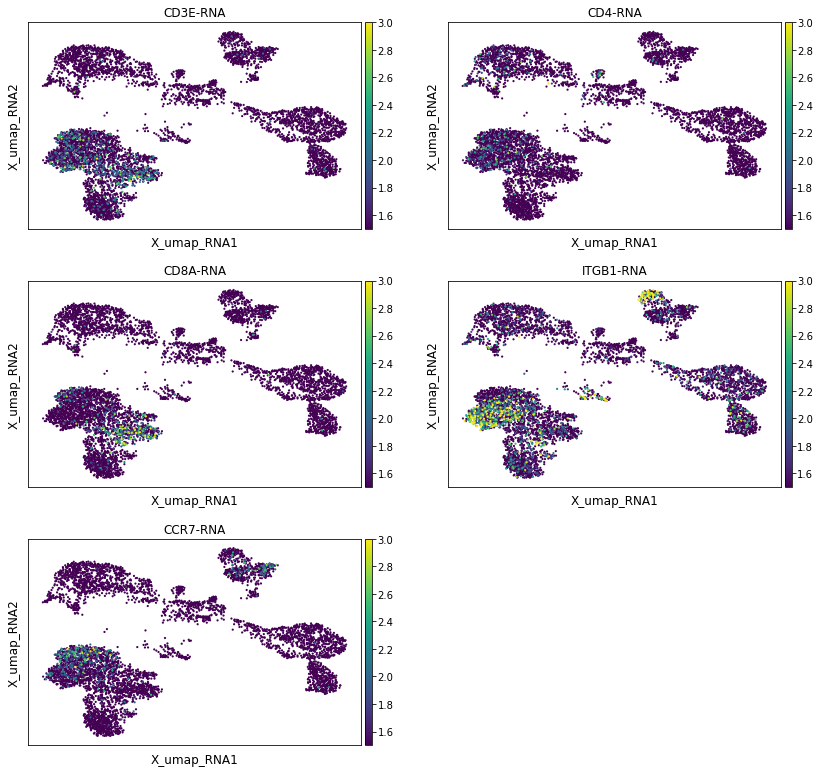

In [14]:
# dissection for the T-cell subtypes
sc.pl.embedding(adata, basis="X_umap_RNA", 
                color=["CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                vmin=[1.5, 1.5, 1.5, 1.5, 1.5],
                vmax=[3.0, 3.0, 3.0, 3.0, 3.0],
                ncols=2)

In [ ]:
['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Erythroblast',
 'CD8+ T',
 'naive CD20+ B',
 'CD14+ Mono',
 'HSC',
 'NK',
 'pDC',
 'B1 B',
 'G/M prog',
 'Normoblast',
 'CD16+ Mono',
 'MK/E prog',
 'ILC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'cDC2',
 'Transitional B',
 'Plasma cells']

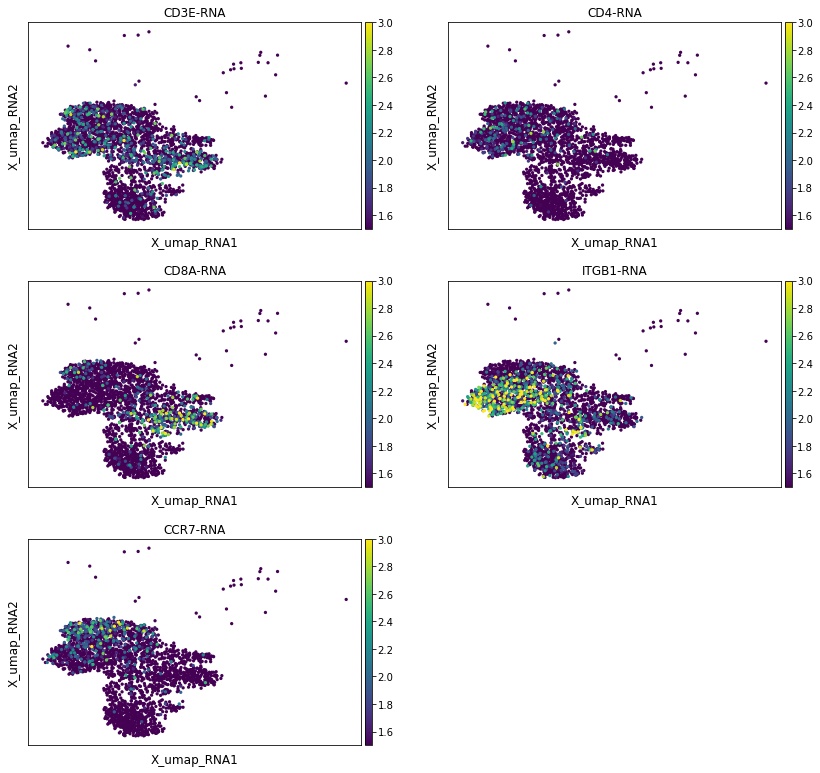

In [17]:
# dissection for the T-cell subtypes
sc.pl.embedding(adata[adata.obs["cell_type"].isin(["CD4+ T naive", "CD4+ T activated","CD8+ T","NK","ILC"])], 
                basis="X_umap_RNA", 
                color=["CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                vmin=[1.5, 1.5, 1.5, 1.5, 1.5],
                vmax=[3.0, 3.0, 3.0, 3.0, 3.0],
                ncols=2)

In [18]:
# read in the re-computed UMAP (sub-clustering visualization)
adata_sub = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/umap_RNA__umap_637e55e9.h5ad")
adata_sub

AnnData object with n_obs × n_vars = 2775 × 36271
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC'
    var: 'name_0', 'assay', 'mean', 'variance'
    uns: 'N_umap_637e55e9_params'
    obsm: 'X_latent_pca', 'X_umap_637e55e9'
    layers: 'X'
    obsp: 'N_umap_637e55e9'

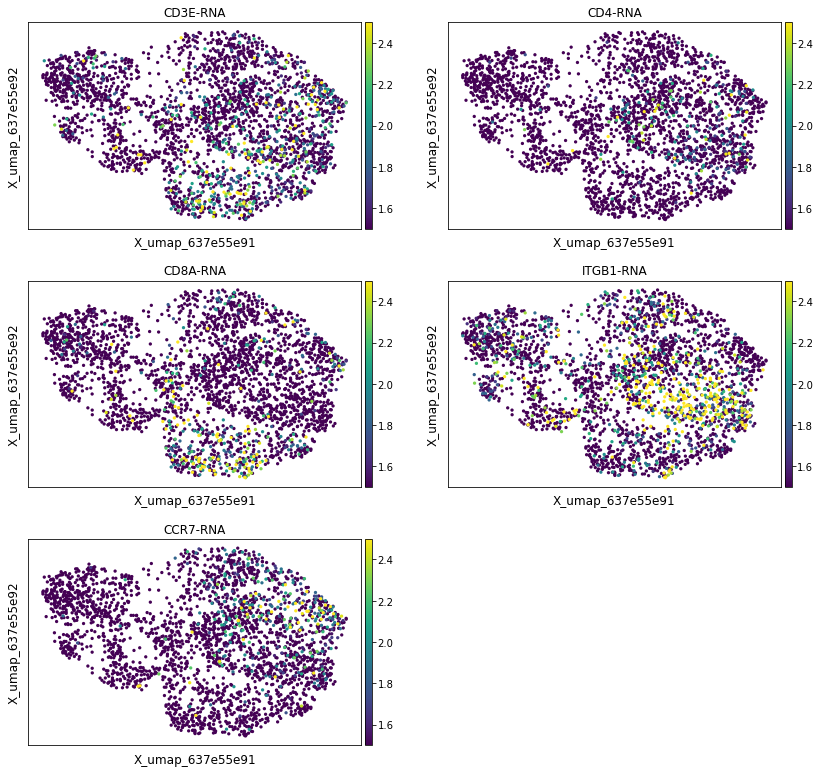

In [21]:
sc.pl.embedding(adata_sub, 
                basis="X_umap_637e55e9", 
                color=["CD3E-RNA","CD4-RNA","CD8A-RNA","ITGB1-RNA","CCR7-RNA"], 
                vmin=[1.5, 1.5, 1.5, 1.5, 1.5],
                vmax=[2.5, 2.5, 2.5, 2.5, 2.5],
                ncols=2)

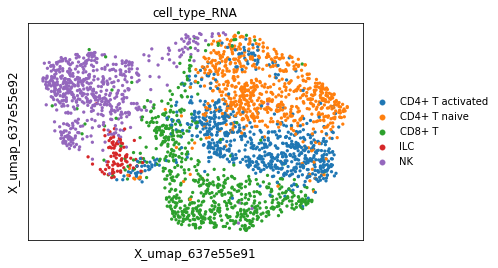

In [24]:
sc.pl.embedding(adata_sub, 
                basis="X_umap_637e55e9", 
                color="cell_type_RNA")

# Annotation done again using exCellxgene - coarse/fine level for T cells and progenitor population only

- last updated: 12/21/2022


In [31]:
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_processed_annotated_forViz.h5ad")
adata

AnnData object with n_obs × n_vars = 6224 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'annotation_for_visualization'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    obsm: 'X_latent_pca', 'X_pca', 'X_umap'
    layers: 'X', 'counts'
    obsp: 'N_pca', 'N_umap'

In [32]:
adata.obs["annotation_for_visualization"].unique()

['unassigned', 'T_cells']
Categories (2, object): ['T_cells', 'unassigned']

In [33]:
adata.obs["manual_annotation"].unique()

['unassigned', 'CD4+T', 'CD8+T', 'Lymph_prog', 'NK', 'HSC', 'MK_E_prog', 'pDC', 'G_M_prog']
Categories (9, object): ['CD4+T', 'CD8+T', 'G_M_prog', 'HSC', ..., 'MK_E_prog', 'NK', 'pDC', 'unassigned']

In [30]:
adata[adata.obs["annotation_for_visualization"]=="T_cells"]

View of AnnData object with n_obs × n_vars = 2775 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'annotation_for_visualization'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    obsm: 'X_latent_pca', 'X_pca', 'X_umap'
    layers: 'X', 'counts'
    obsp: 'N_pca', 'N_umap'

In [26]:
adata_test = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/umap__umap_638f9aee.h5ad")
adata_test

AnnData object with n_obs × n_vars = 404 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    uns: 'N_umap_638f9aee_params'
    obsm: 'X_latent_pca', 'X_umap_638f9aee'
    layers: 'X', 'counts'
    obsp: 'N_umap_638f9aee'

In [75]:
adata.obs["annotation_for_visualization"].cat = adata.obs["annotation_for_visualization"].cat.add_categories("progenitors")
adata.obs["annotation_for_visualization"].cat

TAGTTGTCACCCTCAC-1    unassigned
CTATGGCCATAACGGG-1    unassigned
CCGCACACAGGTTAAA-1       T_cells
TCATTTGGTAATGGAA-1       T_cells
ACCACATAGGTGTCCA-1    unassigned
                         ...    
AGACCCGGTTATCCTA-1       T_cells
GACCTAAGTGCCTCAC-1    unassigned
AGCTCATAGCTATATG-1       T_cells
TACGTACAGGAAACTG-1       T_cells
GGTTTCTGTTTATCTG-1       T_cells
Name: annotation_for_visualization, Length: 6224, dtype: category
Categories (3, object): ['T_cells', 'unassigned', 'progenitors']

In [ ]:
# A tip on how to play with the categorical data/order: From https://stackoverflow.com/questions/54422643/how-can-i-add-new-category-in-a-categorical-variables-after-a-qcut
# cat = df['Score_pr'].cat.categories.tolist()
# cat = cat[:-1]
# cat.insert(0, '0')
# series = pd.Series(cat)
# df['Score_pr'] = df['Score_pr'].cat.reorder_categories(series)

In [91]:
adata.obs.loc[adata.obs_names.isin(adata_test.obs_names),"annotation_for_visualization"] = 'T_cells'

## Let's just generate the figure panels without re-defining the adata.obs values

In [104]:
# redefine the color dict for the manual_annotation
# Note: We can always come back and change the color scheme. Maybe Ask Alejandro if he has a preferred set of colors
# It would be challenging to make this consistent with exCellxgene colorset, but definitely an option to try.
adata.uns["manual_annotation_colors"] = ['#1f77b4', '#ff7f0e', '#2ca02c', 
                                         '#d62728', '#9467bd', '#8c564b', 
                                         '#e377c2', '#bcbd22', '#A9A9A9']

In [116]:
# cxg_colors = color_schema.convert_anndata_category_colors_to_cxg_category_colors(adata)
# cxg_colors

{'manual_annotation': {'CD4+T': '#1f77b4',
  'CD8+T': '#ff7f0e',
  'G_M_prog': '#2ca02c',
  'HSC': '#d62728',
  'Lymph_prog': '#9467bd',
  'MK_E_prog': '#8c564b',
  'NK': '#e377c2',
  'pDC': '#bcbd22',
  'unassigned': '#a9a9a9'}}

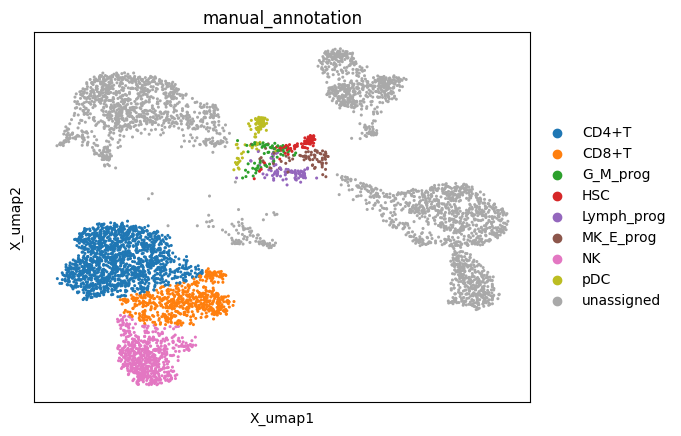

In [119]:
sc.pl.embedding(adata, basis="X_umap",color="manual_annotation")

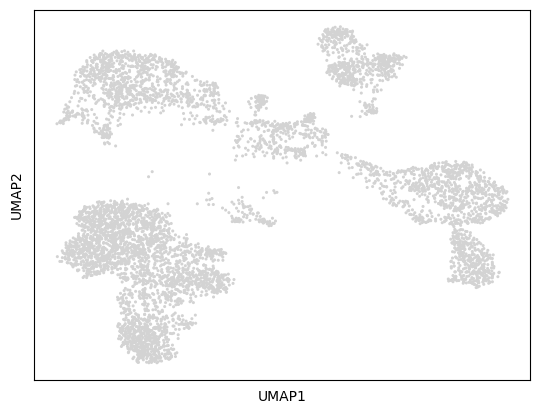

In [122]:
sc.pl.umap(adata, save="_basic_no_color.pdf")

In [97]:
adata.obs["manual_annotation"].unique()

['unassigned', 'CD4+T', 'CD8+T', 'Lymph_prog', 'NK', 'HSC', 'MK_E_prog', 'pDC', 'G_M_prog']
Categories (9, object): ['CD4+T', 'CD8+T', 'G_M_prog', 'HSC', ..., 'MK_E_prog', 'NK', 'pDC', 'unassigned']

In [101]:
adata.obs["manual_annotation"].cat.categories

Index(['CD4+T', 'CD8+T', 'G_M_prog', 'HSC', 'Lymph_prog', 'MK_E_prog', 'NK',
       'pDC', 'unassigned'],
      dtype='object')

In [102]:
adata.uns

#['#1f77b4', '#ff7f0e', '#2ca02c', '#A9A9A9']

In [48]:
adata.obs.loc[adata.obs_names.isin(adata_test.obs_names)]["annotation_for_visualization"] = "progenitors"
adata

/tmp/ipykernel_1318712/580462805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.loc[adata.obs_names.isin(adata_test.obs_names)]["annotation_for_visualization"] = "progenitors"


AnnData object with n_obs × n_vars = 6224 × 17739
    obs: 'name_0', 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX', 'manual_annotation', 'annotation_for_visualization'
    var: 'name_0', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'mean', 'variance'
    obsm: 'X_latent_pca', 'X_pca', 'X_umap'
    layers: 'X', 'counts'
    obsp: 'N_pca', 'N_umap'

In [46]:
adata.obs["annotation_for_visualization"].unique()

['unassigned', 'T_cells']
Categories (2, object): ['T_cells', 'unassigned']

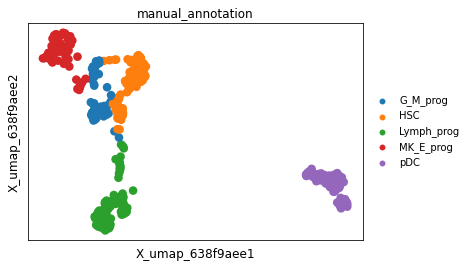

In [27]:
sc.pl.embedding(adata_test, basis="X_umap_638f9aee", color="manual_annotation")

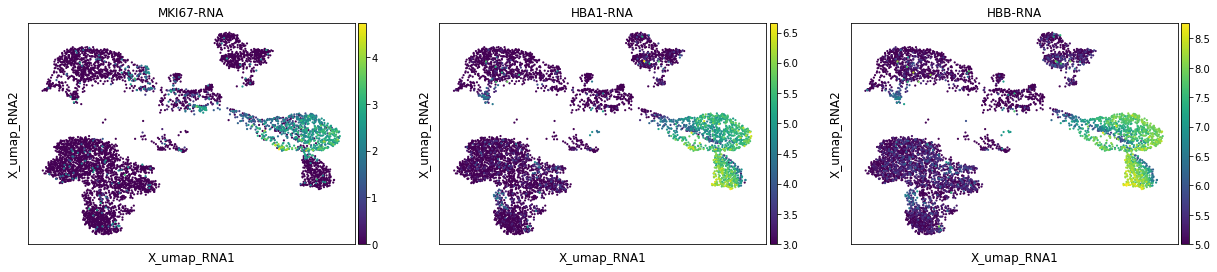

In [72]:
sc.pl.embedding(adata, basis="X_umap_RNA", color=marker_genes_rna["Erythroblast"],
                vmin=[0, 3, 5])

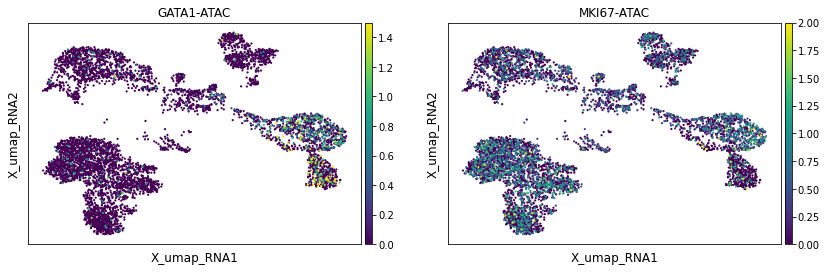

In [78]:
sc.pl.embedding(adata, basis="X_umap_RNA", color=marker_genes_atac["Erythroblast"],
                vmin=[0, 0], vmax=[1.5,2])

### summation of log-normalized counts for several marker genes


In [67]:
# define the gene sets for RNA and ATAC modalities
gene_sets = marker_genes_rna["Erythroblast"] + marker_genes_atac["Erythroblast"]
gene_sets

# make a dataframe of count matrices for easier slicing
count_matrices = pd.DataFrame(data=adata.X.todense(),
                              index=adata.obs_names,
                              columns=adata.var_names)
count_matrices

# add a new adata.obs for the summation of log-normalized counts
adata.obs["erythroblast_score"] = np.sum(count_matrices.loc[:,gene_sets],1)

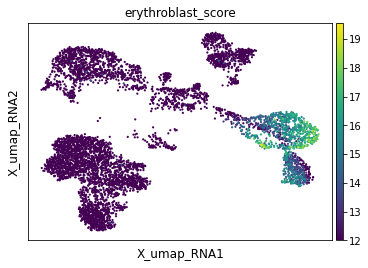

In [71]:
sc.pl.embedding(adata, basis="X_umap_RNA", color=["erythroblast_score"], vmin=12)

In [ ]:
# #RNA
# marker_genes_rna = {
#     'CD14+ Mono': ['FCN1', 'CD14'],
#     'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
#     'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
#     'cDC1': ['CLEC9A', 'CADM1'],
#     'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
#     'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
#     'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
#     'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers
#     'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'],
#     'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
#     'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],
#     'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
#     'B1 B': ['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'], # Note IGHD and IGHM are negative markers
#     'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
#     'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
#     'Plasmablast': ['XBP1', 'RF4', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker
#     'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
#     'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
#     'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
#     'T activation': ['CD69', 'CD38'], # CD69 much better marker!
#     'T naive': ['LEF1', 'CCR7', 'TCF7'],
#     'pDCs': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
#     'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'],
#     'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'],
#     'MK/E prog': ['ZNF385D', 'ITGA2B', 'RYR3', 'PLCB1'] # Note PLCB1 is a negative marker
# }

# #ATAC
# marker_genes_atac = {
#     'CD14+ Mono': ['TREM1', 'FPR1'],
#     'CD16+ Mono': ['LYN', 'TCF7L2'],
#     'ID2-hi myeloid prog': ['KLF4'],
#     'cDC2': ['TREM1', 'DMXL2'], # Note: DMXL2 should be negative
#     'Reticulocyte': ['GATA1', 'HBA1', 'SLC4A1', 'SLC25A37', 'KLF1'],
#     'Erythroblast': ['GATA1', 'MKI67'],
#     'Proerythroblast': ['GATA2', 'CRACD', 'SYNGR1'],
#     'NK': ['CD160', 'GNLY', 'GRIK4', 'CD247'],
#     'ILC': ['SPON2', 'GZMB', 'PRF1', 'C69'], # Note CD69 should be negative
#     'Lymph prog': ['MME', 'IGLL1', 'VPREB1', 'CD79B'],
#     'Naive CD20+ B': ['MS4A1', 'LYN', 'CD74', 'BLK'],
#     'B1 B': ['ITGB1', 'MS4A1', 'DUSP22', 'EPHA4'],
#     'Transitional B': ['MME', 'CD38', 'CD24'],
#     'Plasma cells': ['DUSP22', 'FNDC3B'],
#     'CD4+ T activated': ['JAKMIP1', 'C4orf50'],
#     'CD4+ T naive': [ 'BCL11B', 'BACH2', 'JAKMIP1', 'C4orf50'], # Note JAKMIP1 and C4orf50 are negative markers
#     'CD8+ T': ['CD8A', 'CD8B'],
#     'pDCs': ['PTPRS', 'TCF4', 'KCNN3', 'DUSP22'],
#     'G/M prog': ['MPO','NT5DC3'],
#     'HSC': ['PRDM16','TAMALIN','MTRNR2L1'],
#     'MK/E prog': ['DNAJC6']
# }

